📊 Loaded 5000 reviews with features
✅ Data prepared
   Training: 4000 samples
   Testing: 1000 samples

🤖 MODEL 1: Logistic Regression

✅ Accuracy: 0.8150 (81.50%)

Classification Report:
              precision    recall  f1-score   support

        Real       0.81      0.83      0.82       509
        Fake       0.82      0.80      0.81       491

    accuracy                           0.81      1000
   macro avg       0.82      0.81      0.81      1000
weighted avg       0.82      0.81      0.81      1000


🤖 MODEL 2: Random Forest

✅ Accuracy: 0.8350 (83.50%)

Classification Report:
              precision    recall  f1-score   support

        Real       0.83      0.84      0.84       509
        Fake       0.84      0.83      0.83       491

    accuracy                           0.83      1000
   macro avg       0.84      0.83      0.83      1000
weighted avg       0.84      0.83      0.83      1000


📊 Top 10 Feature Importances:
                   feature  importance
2        

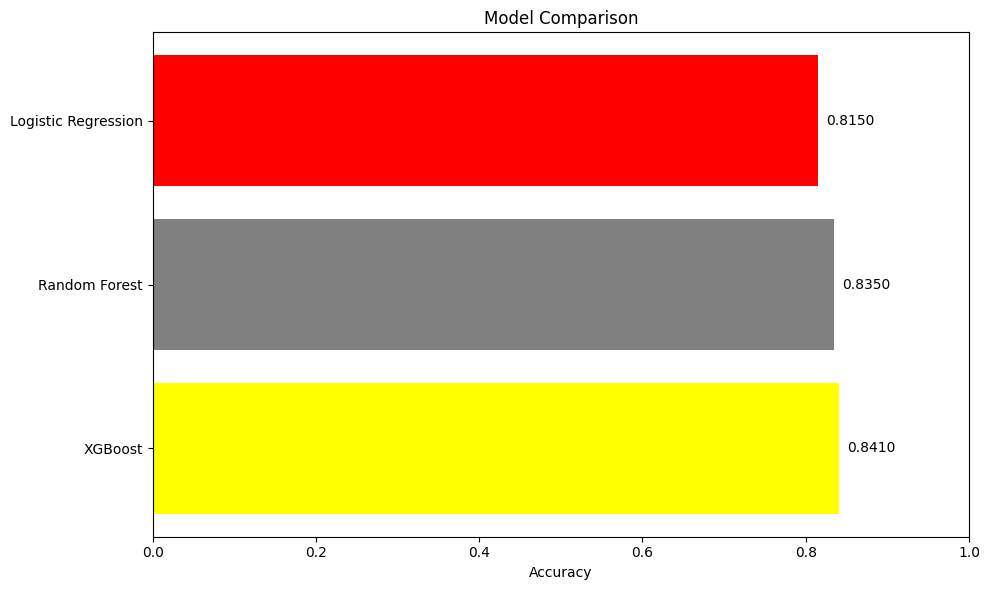


📊 Confusion Matrices


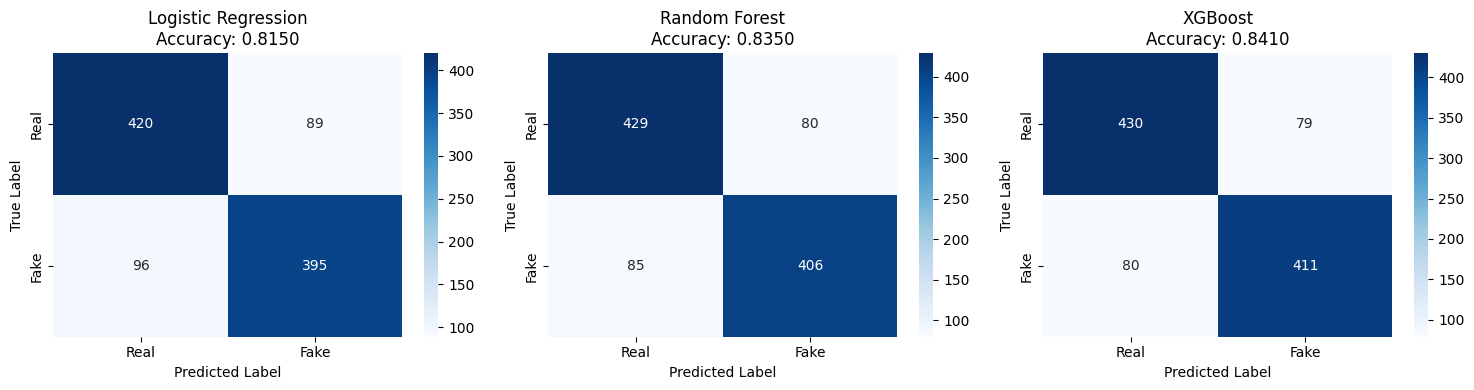


📊 ROC Curves


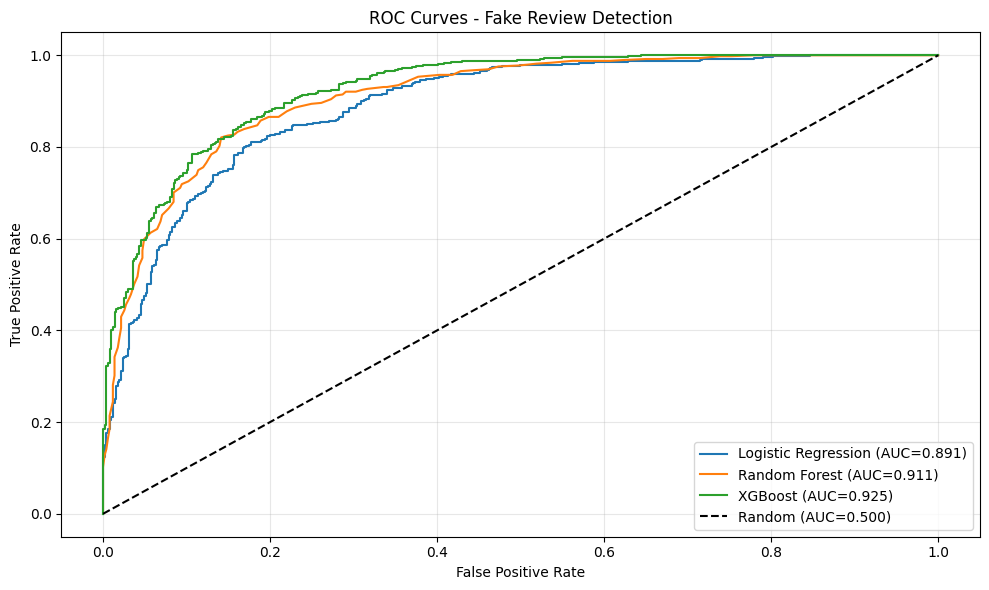


💾 Saving best model...
🏆 Best model: XGBoost (0.8410)
✅ Model saved to: ..\models

✅ ML TRAINING COMPLETE!

🏆 Best Model: XGBoost
📊 Accuracy: 0.8410 (84.10%)
💾 Saved to: models/fake_review_detector_xgboost.pkl


In [1]:
"""
04 - ML Models for Fake Review Detection
"""

# %%
# Imports
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# ML imports
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, precision_recall_fscore_support,
    roc_auc_score, roc_curve
)
import xgboost as xgb

# %%
# Load features
df = pd.read_csv('../data/processed/reviews_with_features.csv')
print(f"📊 Loaded {len(df)} reviews with features")

# %%
# Prepare data
feature_columns = [
    'text_length', 'word_count', 'avg_word_length',
    'exclamation_count', 'question_count', 'capital_ratio',
    'digit_count', 'unique_word_ratio', 'sentence_count',
    'sentiment_polarity', 'sentiment_subjectivity',
    'rating', 'is_extreme_rating', 'is_very_short', 'is_very_long'
]

X = df[feature_columns]
y = df['is_fake']

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"✅ Data prepared")
print(f"   Training: {len(X_train)} samples")
print(f"   Testing: {len(X_test)} samples")

# %%
# === MODEL 1: Logistic Regression ===
print("\n" + "="*70)
print("🤖 MODEL 1: Logistic Regression")
print("="*70)

lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_scaled, y_train)

lr_pred = lr_model.predict(X_test_scaled)
lr_acc = accuracy_score(y_test, lr_pred)

print(f"\n✅ Accuracy: {lr_acc:.4f} ({lr_acc*100:.2f}%)")
print("\nClassification Report:")
print(classification_report(y_test, lr_pred, target_names=['Real', 'Fake']))

# %%
# === MODEL 2: Random Forest ===
print("\n" + "="*70)
print("🤖 MODEL 2: Random Forest")
print("="*70)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

rf_pred = rf_model.predict(X_test)
rf_acc = accuracy_score(y_test, rf_pred)

print(f"\n✅ Accuracy: {rf_acc:.4f} ({rf_acc*100:.2f}%)")
print("\nClassification Report:")
print(classification_report(y_test, rf_pred, target_names=['Real', 'Fake']))

# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n📊 Top 10 Feature Importances:")
print(feature_importance.head(10))

# %%
# === MODEL 3: XGBoost ===
print("\n" + "="*70)
print("🤖 MODEL 3: XGBoost")
print("="*70)

xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)
xgb_model.fit(X_train, y_train)

xgb_pred = xgb_model.predict(X_test)
xgb_acc = accuracy_score(y_test, xgb_pred)

print(f"\n✅ Accuracy: {xgb_acc:.4f} ({xgb_acc*100:.2f}%)")
print("\nClassification Report:")
print(classification_report(y_test, xgb_pred, target_names=['Real', 'Fake']))

# %%
# === MODEL COMPARISON ===
print("\n" + "="*70)
print("📊 MODEL COMPARISON")
print("="*70)

models_results = {
    'Logistic Regression': lr_acc,
    'Random Forest': rf_acc,
    'XGBoost': xgb_acc
}

results_df = pd.DataFrame({
    'Model': list(models_results.keys()),
    'Accuracy': list(models_results.values())
}).sort_values('Accuracy', ascending=False)

print(results_df.to_string(index=False))

# Visualize
plt.figure(figsize=(10, 6))
plt.barh(results_df['Model'], results_df['Accuracy'], color=['yellow', 'gray', 'red'])
plt.xlabel('Accuracy')
plt.title('Model Comparison')
plt.xlim([0, 1])
for i, v in enumerate(results_df['Accuracy']):
    plt.text(v + 0.01, i, f'{v:.4f}', va='center')
plt.tight_layout()
plt.show()

# %%
# === CONFUSION MATRICES ===
print("\n📊 Confusion Matrices")

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

models = [
    ('Logistic Regression', lr_pred),
    ('Random Forest', rf_pred),
    ('XGBoost', xgb_pred)
]

for idx, (name, pred) in enumerate(models):
    cm = confusion_matrix(y_test, pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Real', 'Fake'],
                yticklabels=['Real', 'Fake'])
    axes[idx].set_title(f'{name}\nAccuracy: {accuracy_score(y_test, pred):.4f}')
    axes[idx].set_ylabel('True Label')
    axes[idx].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

# %%
# === ROC CURVES ===
print("\n📊 ROC Curves")

plt.figure(figsize=(10, 6))

# Logistic Regression
lr_proba = lr_model.predict_proba(X_test_scaled)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_proba)
auc_lr = roc_auc_score(y_test, lr_proba)
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC={auc_lr:.3f})')

# Random Forest
rf_proba = rf_model.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_proba)
auc_rf = roc_auc_score(y_test, rf_proba)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC={auc_rf:.3f})')

# XGBoost
xgb_proba = xgb_model.predict_proba(X_test)[:, 1]
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_proba)
auc_xgb = roc_auc_score(y_test, xgb_proba)
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC={auc_xgb:.3f})')

# Random baseline
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC=0.500)')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Fake Review Detection')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# %%
# === SAVE BEST MODEL ===
print("\n💾 Saving best model...")

best_model_name = results_df.iloc[0]['Model']
best_accuracy = results_df.iloc[0]['Accuracy']

print(f"🏆 Best model: {best_model_name} ({best_accuracy:.4f})")

# Save XGBoost (usually best)
import joblib

model_dir = Path('../models')
model_dir.mkdir(exist_ok=True)

joblib.dump(xgb_model, model_dir / 'fake_review_detector_xgboost.pkl')
joblib.dump(scaler, model_dir / 'feature_scaler.pkl')

# Save feature names
with open(model_dir / 'feature_names.txt', 'w') as f:
    f.write('\n'.join(feature_columns))

print(f"✅ Model saved to: {model_dir}")

# %%
print("\n" + "="*70)
print("✅ ML TRAINING COMPLETE!")
print("="*70)
print(f"\n🏆 Best Model: {best_model_name}")
print(f"📊 Accuracy: {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")
print(f"💾 Saved to: models/fake_review_detector_xgboost.pkl")